In [41]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import scipy as sc
import os
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import QuantileRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import glob

## Data Imports

In [42]:
## HRDPS PCs 2007
hr_PCs_2007 = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_hrdps_annual.csv', header = None) )
hr_PCs_2007.shape

(136192, 50)

In [43]:
##CANRCM analysis results for 2007
eigs_2007 = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/eigvecs_winds.csv', header = None) )
PCs_2007 = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/PCs_winds.csv', header = None) )

In [44]:
##importing linear model coeficients (based on comparing 2007 HRDPS and CANRCM data)
mrl_out = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/coeficients_2007.csv', header = None) )
mrl_coefs = mrl_out[:,0:-1]
mrl_inter = mrl_out[:,-1]
energy_coefs = np.array( pd.read_csv('/ocean/arandhawa/MOAD/analysis-armaan/notebooks/energy_coeficients_2007.csv', header = None) )

## Functions

In [45]:
##data must be converted into a 2D matrix for pca analysis
##transform takes a 3D data array (time, a, b) -> (a*b, time)
##(the data grid is flattened a column using numpy.flatten)

def transform(xarr):
    arr = np.array(xarr) ##converting to numpy array
    arr = arr.reshape(arr.shape[0], arr.shape[1]*arr.shape[2]) ##reshaping from size (a, b, c) to (a, b*c)
    arr = arr.transpose()
    return arr

def reverse(mat, orig_shape):
    arr = np.copy(mat)
    arr = arr.transpose()
    arr = arr.reshape(-1, orig_shape[1], orig_shape[2]) ##reshaping back to original array shape
    return arr

In [46]:
##graphing percentage of original data represented by the first n principle conponents
def graph_variance(matrix, n):
    pcaG = PCA(n_components = n) ##Number of principle conponents to show
    PCsG = pcaG.fit_transform(matrix)
    plt.plot(np.cumsum(pcaG.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    plt.show()
    del pcaG
    del PCsG

In [47]:
def get_mode(PCs, n, arr_orig): ##converts PCs (column vectors) to 2d conpoents for u and v wind
    split = int(PCs.shape[0]/2)
    mode_u = PCs[:split, n].reshape(arr_orig.shape[1], arr_orig.shape[2])
    mode_v = PCs[split:, n].reshape(arr_orig.shape[1], arr_orig.shape[2])
    return (mode_u, mode_v)

def graph_nPCs(PCs, eigvecs, n, arr_orig):
    fig, ax = plt.subplots(n, 3, figsize=(10, 3*n))
    
    ax[0, 0].set_title("u-conponent")
    ax[0, 1].set_title("v-component")
    ax[0, 2].set_title("time-loadings")
    
    for i in range(n):
        mode_u, mode_v = get_mode(PCs, i, arr_orig)
        colors = ax[i, 0].pcolormesh(mode_u, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,0])
        colors = ax[i, 1].pcolormesh(mode_v, cmap = 'bwr')
        fig.colorbar(colors, ax = ax[i,1])
        ax[i, 2].plot(eigvecs[i])

    plt.tight_layout()
    plt.show()

## 2008 HRDPS

In [82]:
files = glob.glob('/results/forcing/atmospheric/GEM2.5/gemlam/gemlam_y2008m??d??.nc')
##list of data files, febrary 2007 - each file covers one day, with hourly data
##the grid is 266 by 256 points, with resolution 2.5km
##relevant data in this file is u_wind and v_wind data
files.sort()
print(len(files))

## 3-hour averaged matrix

u_data = np.empty( (8*len(files), 266, 256)) 
v_data = np.empty( (8*len(files), 266, 256)) 

for i in range(len(files)):
    dayX = xr.open_dataset(files[i])
    for j in range(8):
        u_3 = np.array( dayX['u_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        v_3 = np.array( dayX['v_wind'][j*3:j*3 + 3, 0:266, 0:256] )
        avg_u = u_3.mean(axis = 0) ##average of 3-hour time interval
        avg_v = v_3.mean(axis = 0)
        u_data[8*i + j, : , : ] = avg_u[0:266, 0:256] ##adding 3-hour average to new data array
        v_data[8*i + j, : , : ] = avg_v[0:266, 0:256]

del u_3
del avg_u
del avg_v
del dayX

366


In [92]:
u_data = u_data[8:,:,:]
v_data = v_data[8:,:,:]

In [93]:
u_data.shape

(2920, 266, 256)

## PCA on 2008 data

In [81]:
##supposed to be 2008 canrcm data
p1 = '/home/arandhawa/canrcm_2008_uas.nc'
p2 = '/home/arandhawa/canrcm_2008_vas.nc'

d1 = xr.open_dataset(p1)
d2 = xr.open_dataset(p2)

A = d1['uas'][:,140:165,60:85]
B = d2['vas'][:,140:165,60:85]

In [90]:
print(A.shape)

(2920, 25, 25)


In [91]:
print(d1)

<xarray.Dataset>
Dimensions:       (time: 2920, bnds: 2, rlon: 310, rlat: 260)
Coordinates:
  * time          (time) object 2008-01-01 03:00:00 ... 2009-01-01 00:00:00
  * rlon          (rlon) float64 -33.99 -33.77 -33.55 ... 33.55 33.77 33.99
  * rlat          (rlat) float64 -28.71 -28.49 -28.27 ... 27.83 28.05 28.27
    lon           (rlat, rlon) float64 ...
    lat           (rlat, rlon) float64 ...
Dimensions without coordinates: bnds
Data variables:
    time_bnds     (time, bnds) object ...
    rotated_pole  |S1 ...
    uas           (time, rlat, rlon) float32 ...
Attributes: (12/26)
    title:                          CanRCM4 model output prepared for CORDEX ...
    institution:                    CCCma (Canadian Centre for Climate Modell...
    institute_id:                   CCCma
    experiment:                     Evaluation run with ERA-INTERIM reanalysi...
    experiment_id:                  evaluation
    driving_experiment:             ECMWF-ERAINT, evaluation, r1i1p1
   

In [50]:
A_mat = transform(A)
B_mat = transform(B)
C_mat = np.concatenate((A_mat,B_mat), axis=0) 
del A_mat
del B_mat

##conducting PCA analysis on combined data matrix
pca = PCA(n_components = 30) ##adjust the number of principle conponents to be calculated
PCs = pca.fit_transform(C_mat)
eigvecs = pca.components_
mean_2008 = pca.mean_

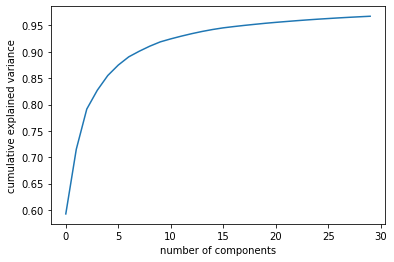

In [51]:
graph_variance(C_mat, 30)

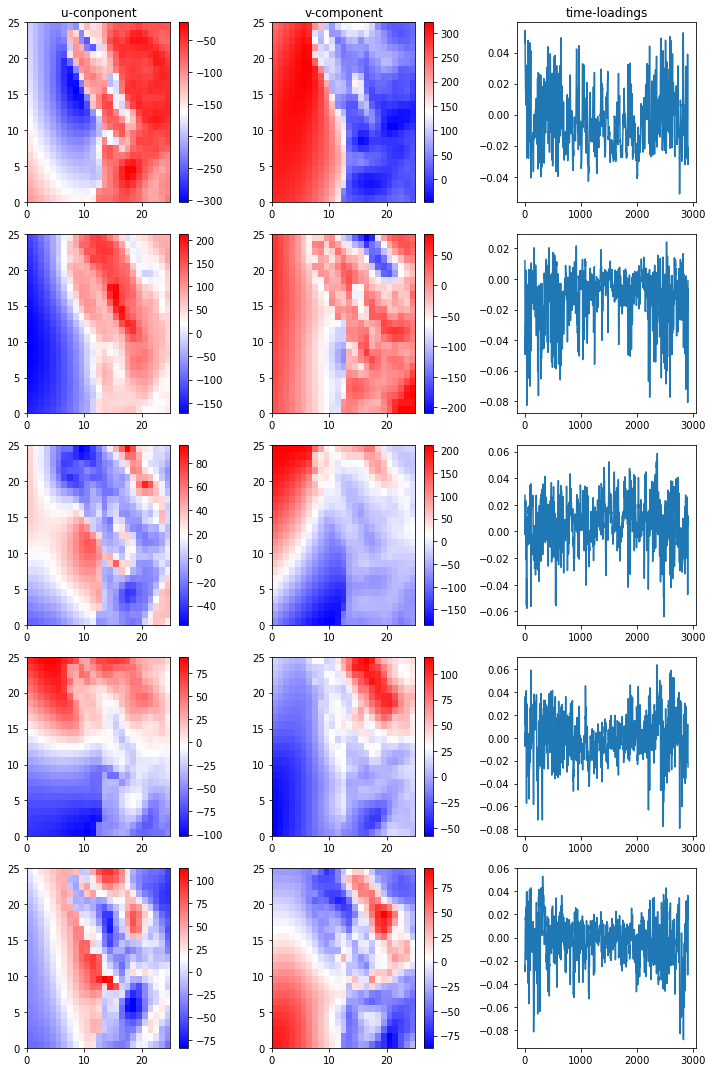

In [52]:
graph_nPCs(PCs, eigvecs, 5, A)

## Predictions

In [53]:
def project(u, v):  ##scalar projection of u onto v - with extra 1/norm factor (for math reasons)
    v_norm = np.sqrt(np.sum(v**2))    
    return np.dot(u, v)/v_norm**2

In [54]:
C_mat.shape

(1250, 2920)

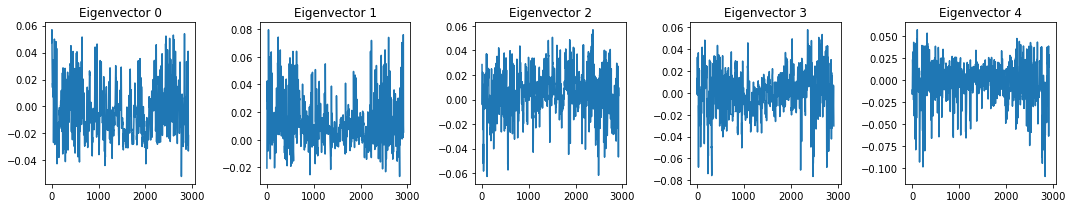

In [84]:
n = 30
proj = np.empty((n, A.shape[0]))

for j in range(n):
    for i in range(A.shape[0]):
        proj[j, i] = project(C_mat[:,i], PCs_2007[:,j])
        
fig, ax = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    ax[i].set_title("Eigenvector {}".format(i))
    ax[i].plot(proj[i])
plt.tight_layout()

In [94]:
print(mean_2008.shape)

(2920,)


In [95]:
pred_eigs = np.matmul(mrl_coefs, proj) + mrl_inter.reshape(-1, 1)
pred_eigs = pred_eigs*energy_coefs

In [96]:
recon = np.matmul(hr_PCs_2007[:,0:30], pred_eigs[0:30]) + mean_2008

split4 = int( recon.shape[0]/2 )
u_data_rec = reverse(recon[:split4,:], (-1, 266, 256)) ##reconstructing u_winds from n PCs
v_data_rec = reverse(recon[split4:,:], (-1, 266, 256)) ##reconstructing v_winds from n PCs
del recon

In [97]:
print(u_data_rec.shape)

(2920, 266, 256)


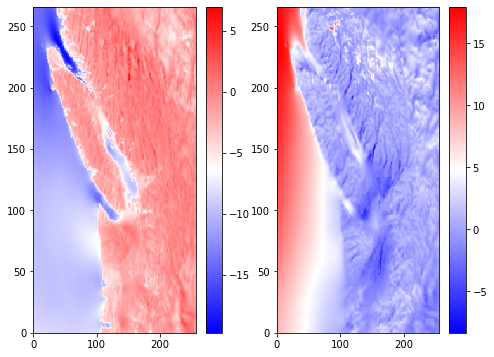

In [98]:
fig, ax = plt.subplots(1, 2, figsize=(8, 6))
colors = ax[0].pcolormesh(u_data_rec[0], cmap = 'bwr')
fig.colorbar(colors, ax = ax[0])
colors = ax[1].pcolormesh(v_data_rec[0], cmap = 'bwr')
fig.colorbar(colors, ax = ax[1])

## Comparison to Original Data

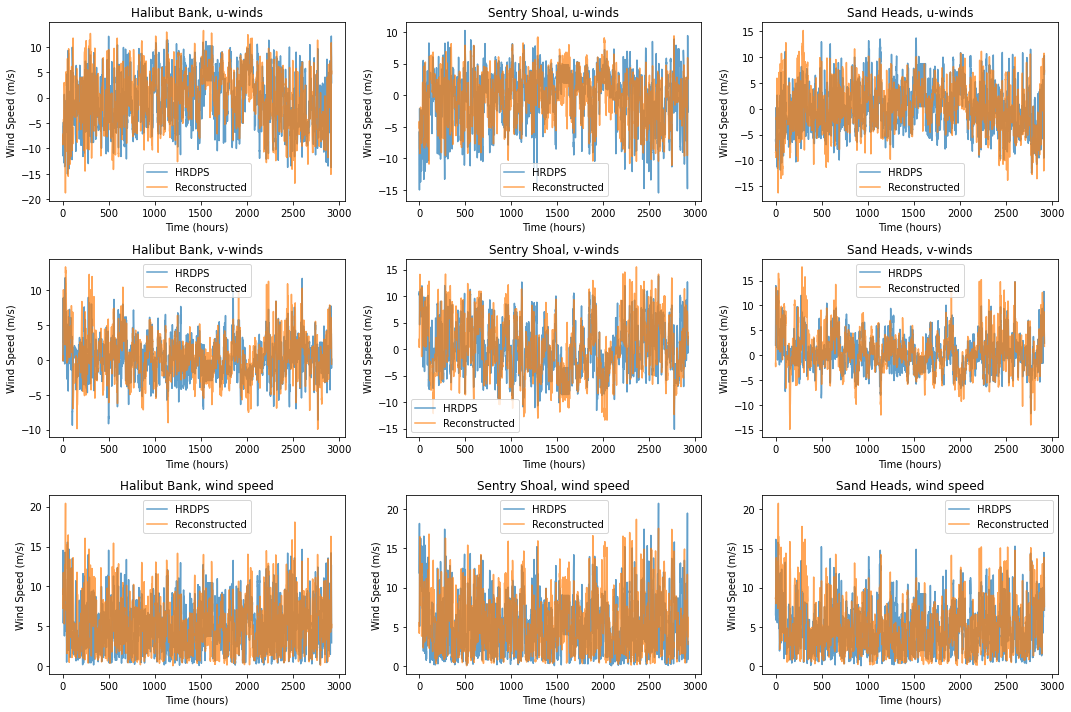

In [99]:
## Plotting data at three locations.

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
alpha_val = 0.7

ax[0, 0].plot(u_data[:,142,139], label = "HRDPS", alpha = alpha_val)
ax[0, 0].plot(u_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[0, 0].set_title("Halibut Bank, u-winds")
ax[0, 0].set_xlabel("Time (hours)")
ax[0, 0].set_ylabel("Wind Speed (m/s)")
ax[0, 0].legend()

ax[0, 1].plot(u_data[:,174,107], label = "HRDPS", alpha = alpha_val)
ax[0, 1].plot(u_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[0, 1].set_title("Sentry Shoal, u-winds")
ax[0, 1].set_xlabel("Time (hours)")
ax[0, 1].set_ylabel("Wind Speed (m/s)")
ax[0, 1].legend()

ax[0, 2].plot(u_data[:,129,149], label = "HRDPS", alpha = alpha_val)
ax[0, 2].plot(u_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[0, 2].set_title("Sand Heads, u-winds")
ax[0, 2].set_xlabel("Time (hours)")
ax[0, 2].set_ylabel("Wind Speed (m/s)")
ax[0, 2].legend()

ax[1, 0].plot(v_data[:,142,139], label = "HRDPS", alpha = alpha_val)
ax[1, 0].plot(v_data_rec[:,142,139], label = "Reconstructed", alpha = alpha_val)
ax[1, 0].set_title("Halibut Bank, v-winds")
ax[1, 0].set_xlabel("Time (hours)")
ax[1, 0].set_ylabel("Wind Speed (m/s)")
ax[1, 0].legend()

ax[1, 1].plot(v_data[:,174,107], label = "HRDPS", alpha = alpha_val)
ax[1, 1].plot(v_data_rec[:,174,107], label = "Reconstructed", alpha = alpha_val)
ax[1, 1].set_title("Sentry Shoal, v-winds")
ax[1, 1].set_xlabel("Time (hours)")
ax[1, 1].set_ylabel("Wind Speed (m/s)")
ax[1, 1].legend()

ax[1, 2].plot(v_data[:,129,149], label = "HRDPS", alpha = alpha_val)
ax[1, 2].plot(v_data_rec[:,129, 149], label = "Reconstructed", alpha = alpha_val)
ax[1, 2].set_title("Sand Heads, v-winds")
ax[1, 2].set_xlabel("Time (hours)")
ax[1, 2].set_ylabel("Wind Speed (m/s)")
ax[1, 2].legend()

ax[2,0].plot(np.sqrt(u_data[:,142,139]**2 + v_data[:,142,139]**2), label = "HRDPS", alpha = alpha_val)
ax[2,0].plot(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,0].set_xlabel("Time (hours)")
ax[2,0].set_title("Halibut Bank, wind speed")
ax[2,0].set_ylabel("Wind Speed (m/s)")
ax[2,0].legend()

ax[2,1].plot(np.sqrt(u_data[:,174,107]**2 + v_data[:,174,107]**2), label = "HRDPS", alpha = alpha_val)
ax[2,1].plot(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), label = "Reconstructed", alpha = alpha_val)
ax[2,1].set_xlabel("Time (hours)")
ax[2,1].set_title("Sentry Shoal, wind speed")
ax[2,1].set_ylabel("Wind Speed (m/s)")
ax[2,1].legend()

ax[2,2].plot(np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2) , label = "HRDPS", alpha = alpha_val)
ax[2,2].plot(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , label = "Reconstructed", alpha = alpha_val)
ax[2,2].set_xlabel("Time (hours)")
ax[2,2].set_title("Sand Heads, wind speed")
ax[2,2].set_ylabel("Wind Speed (m/s)")
ax[2,2].legend()

plt.tight_layout()

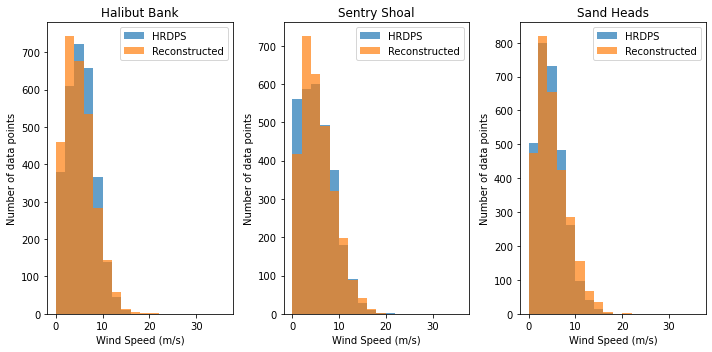

In [62]:
nums = np.arange(0, 37, 2)

fig, ax = plt.subplots(1, 3, figsize=(10, 5))

ax[0].set_title("Halibut Bank")
ax[0].hist(np.sqrt(u_data[:,142,139]**2 + v_data[:,142,139]**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[0].hist(np.sqrt(u_data_rec[:,142,139]**2 + v_data_rec[:,142,139]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[0].set_xlabel("Wind Speed (m/s)")
ax[0].set_ylabel("Number of data points")
ax[0].legend()

ax[1].set_title("Sentry Shoal")
ax[1].hist(np.sqrt(u_data[:,174,107]**2 + v_data[:,174,107]**2), bins = nums, label = "HRDPS", alpha = 0.7)
ax[1].hist(np.sqrt(u_data_rec[:,174,107]**2 + v_data_rec[:,174,107]**2), bins = nums, label = "Reconstructed", alpha = 0.7)
ax[1].set_xlabel("Wind Speed (m/s)")
ax[1].set_ylabel("Number of data points")
ax[1].legend()

ax[2].set_title("Sand Heads")
ax[2].hist(np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2) , bins = nums,  label = "HRDPS", alpha = 0.7)
ax[2].hist(np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2) , bins = nums, label = "Reconstructed", alpha = 0.7)
ax[2].set_xlabel("Wind Speed (m/s)")
ax[2].set_ylabel("Number of data points")
ax[2].legend()

plt.tight_layout()

In [63]:
def helper(x, y, ax, i, j):
    
    if i == 2:
        myBool = False
    else:
        myBool = True
    
    reg = LinearRegression(fit_intercept = myBool).fit(x.reshape(-1, 1), y)
    a = reg.coef_[0]
    b = reg.intercept_
    y_pred = a*x + b
    
    bias = np.mean( y - x )
    r_squared = reg.score(x.reshape(-1, 1), y)
    rmse = np.sqrt( mean_squared_error(y, y_pred) )
    
    ax[i,j].scatter(x, y)
    ax[i,j].plot(x, a*x+b, color = 'orange')
    ax[i,j].annotate("r-squared = {:.3f}".format(r_squared), (-12, 17))
    ax[i,j].annotate("bias = {:.3f}".format(bias), (-12, 15))
    ax[i,j].annotate("RMS error = {:.3f}".format(rmse), (-12, 13))
    ax[i,j].annotate("y = {:.3f}x + {:.3f}".format(a, b), (-12, 11))
    ax[i,j].set_ylabel("HRDPS data")
    ax[i,j].set_xlabel("reconstructed data")
    ax[i,j].set_ylim(-13, 20)
    ax[i,j].set_xlim(-13, 20)
    return (a, b)

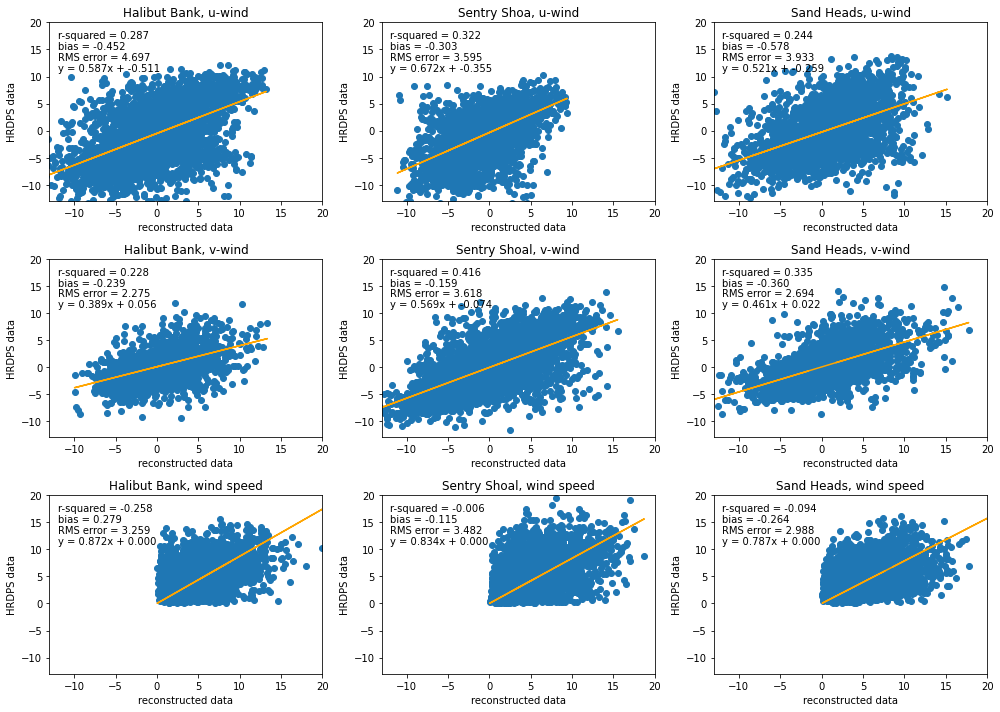

In [100]:
a = np.empty((3, 3))
b = np.empty((3, 3))

fig, ax = plt.subplots(3, 3, figsize = (14, 10))
##Habibut bank
y = u_data[:, 142, 139]
x = u_data_rec[:, 142, 139]
ax[0, 0].set_title("Halibut Bank, u-wind")
a[0,0], b[0,0] = helper(x, y, ax, 0, 0)

y = v_data[:, 142, 139]
x = v_data_rec[:, 142, 139]
ax[1, 0].set_title("Halibut Bank, v-wind")
a[1,0], b[1,0] = helper(x, y, ax, 1, 0)

y = np.sqrt(u_data[:, 142, 139]**2 + v_data[:, 142, 139]**2)
x = np.sqrt(u_data_rec[:, 142, 139]**2 + v_data_rec[:, 142, 139]**2)
ax[2, 0].set_title("Halibut Bank, wind speed")
a[2,0], b[2,0] = helper(x, y, ax, 2, 0)

##Sentry Shoal
y = u_data[:,174, 107]
x = u_data_rec[:,174, 107]
ax[0, 1].set_title("Sentry Shoa, u-wind")
a[0,1], b[0,1] = helper(x, y, ax, 0, 1)

y = v_data[:,174, 107]
x = v_data_rec[:,174, 107]
ax[1, 1].set_title("Sentry Shoal, v-wind")
a[1,1], b[1,1] = helper(x, y, ax, 1, 1)

y = np.sqrt(u_data[:,174, 107]**2 + v_data[:,174, 107]**2)
x = np.sqrt(u_data_rec[:,174, 107]**2 + v_data_rec[:,174, 107]**2)
ax[2, 1].set_title("Sentry Shoal, wind speed")
a[2,1], b[2,1] = helper(x, y, ax, 2, 1)

##Sand Heads
y = u_data[:,129,149]
x = u_data_rec[:,129,149]
ax[0, 2].set_title("Sand Heads, u-wind")
a[0,2], b[0,2] = helper(x, y, ax, 0, 2)

y = v_data[:,129,149]
x = v_data_rec[:,129,149]
ax[1, 2].set_title("Sand Heads, v-wind")
a[1,2], b[1,2] = helper(x, y, ax, 1, 2)

y = np.sqrt(u_data[:,129,149]**2 + v_data[:,129,149]**2)
x = np.sqrt(u_data_rec[:,129,149]**2 + v_data_rec[:,129,149]**2)
ax[2, 2].set_title("Sand Heads, wind speed")
a[2,2], b[2,2] = helper(x, y, ax, 2, 2)

plt.tight_layout()